# Data Preprocessing for Modeling

In this notebook, the preprocessing steps necessary to prepare the dataset for modeling will be executed. These steps include:

1. **Normalization**: Scaling features to bring all numerical variables into the same range, ensuring that no single variable disproportionately influences the model due to differences in scale.
2. **Standardization**: Transforming the data to have a mean of zero and a standard deviation of one, which is particularly beneficial for algorithms sensitive to feature distributions.
3. **Feature Selection**: Identifying and retaining the most relevant variables to reduce dimensionality and enhance model performance while minimizing computational cost.

These preprocessing techniques are critical for ensuring the robustness and accuracy of machine learning models. By the end of this notebook, the dataset will be optimized and ready for model training and evaluation.


In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression

import sys
sys.path.append('../medical_insurance_project/utils/')

import data_explorer as de
import data_scaler as ds

## Data Load and First Visualization

In [123]:
path = '../medical_insurance_project/data/cleaned.csv'

df = pd.read_csv(path)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Transforming categorical features to numerical

In [124]:
cat_features = ['sex','smoker','region']

# Creating dummies
preprocessed = pd.get_dummies(data=df[cat_features]).drop(columns=['sex_female','smoker_no','region_northeast']).astype(int)

# merging dataframes
preprocessed = pd.merge(df.drop(columns=cat_features), preprocessed, left_index=True, right_index=True, how='inner')
preprocessed.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Scaling variables

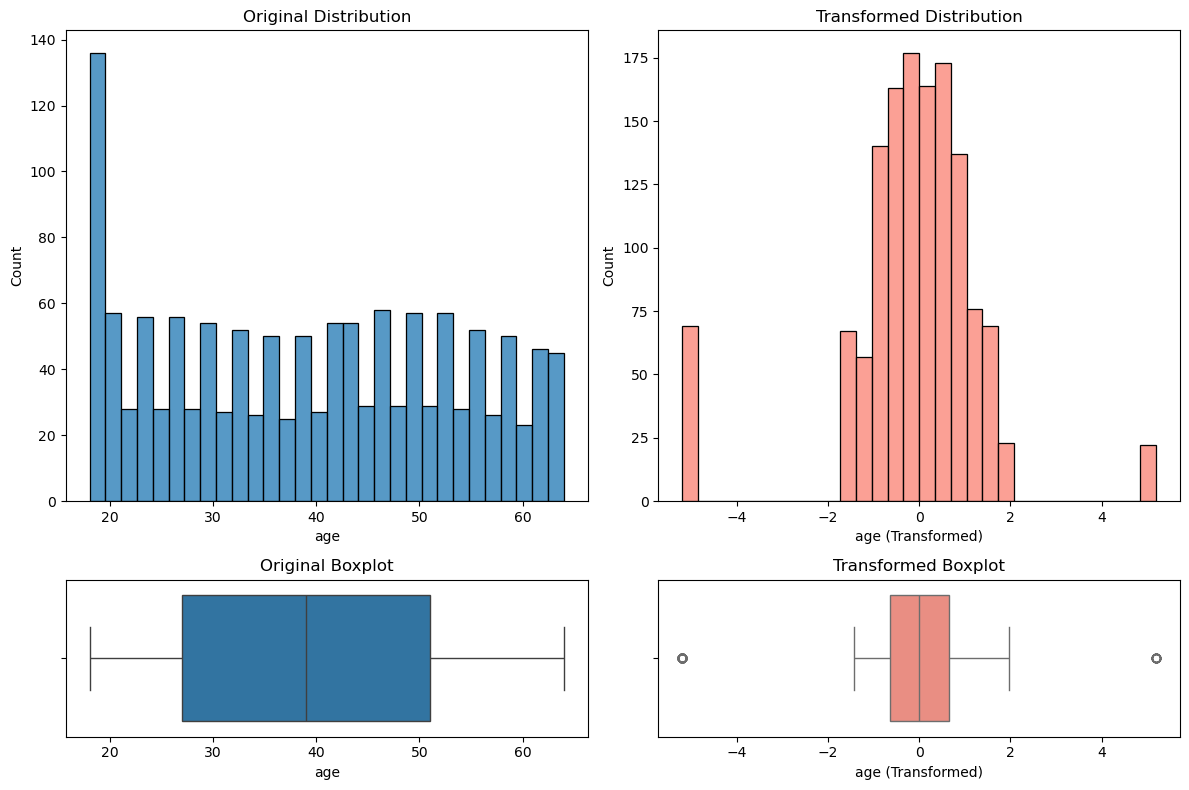

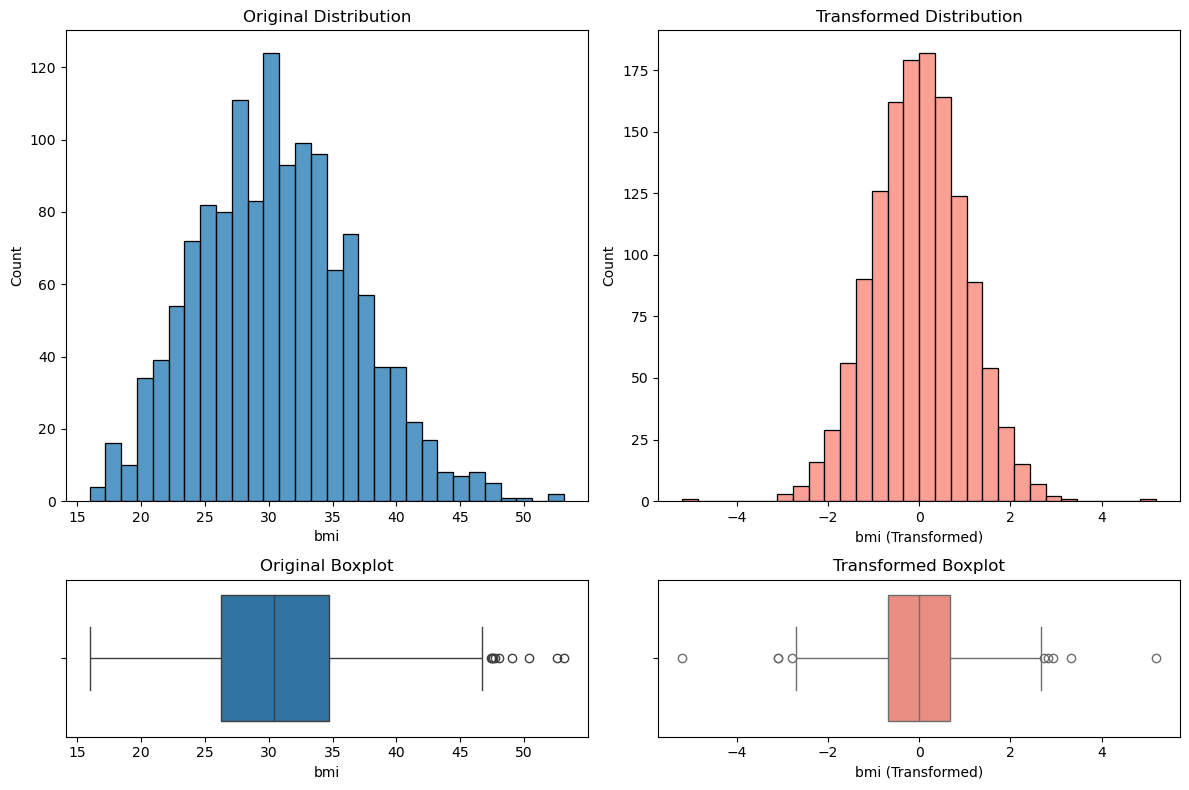

In [125]:
for col in ['age','bmi']:
    preprocessed[col] = ds.apply_transformation(preprocessed,col)


In [126]:
def find_outliers(df, feature):
    Q1, Q3 = df[feature].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    
    # Creating Filters
    high_outliers = df[feature] > (Q3 + 1.5 * IQR)
    low_outliers = df[feature] < (Q1 - 1.5 * IQR)
    
    # Convining both filters
    outliers_df = df[high_outliers | low_outliers]
    
    return outliers_df

#Getting the initial number of records (Before removing outliers)
initial_num_records = preprocessed.shape[0]


while True:
    initial_shape = preprocessed.shape[0] # Number of rows before the iteration
    for col in ['age','bmi']:
        preprocessed = preprocessed.drop(find_outliers(preprocessed, col).index) # Removing outliers
    if initial_shape == preprocessed.shape[0]:    # Condition to stop the while loop
        break

# Getting the Final number of records (After removing outliers)
final_num_records = preprocessed.shape[0]
print(f"Shape before removing outliers: {initial_num_records}\nShape after removing outliers: {final_num_records}")
# Getting the porcentaje of removed data
print(f'{(initial_num_records - final_num_records)/initial_num_records*100}% of the total data was removed.')

Shape before removing outliers: 1337
Shape after removing outliers: 1236
7.554225878833208% of the total data was removed.


## Standardizing variables

In [127]:
num_features = ['age','bmi','children']

preprocessed = preprocessed.copy()

# Initializing the scaler
scaler = MinMaxScaler()
preprocessed[num_features] = pd.DataFrame(
    scaler.fit_transform(preprocessed[num_features]),
    columns=num_features,
    index=preprocessed.index
)
preprocessed.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0.000000,0.414597,0.0,16884.92400,0,1,0,0,1
2,0.249979,0.572109,0.6,4449.46200,1,0,0,1,0
3,0.331601,0.234754,0.0,21984.47061,1,0,1,0,0
4,0.316796,0.446201,0.0,3866.85520,1,0,1,0,0
5,0.300919,0.342121,0.0,3756.62160,0,0,0,1,0


In [128]:
preprocessed.isnull().sum()

age                 0
bmi                 0
children            0
charges             0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

In [129]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

# Splitting the dataframe into Features and target
X = preprocessed.drop(columns=['charges'])
y = preprocessed['charges']

# Getting the correlation values between features and target
corr_preprocessed = abs(preprocessed.corr()['charges']).drop('charges').to_frame()

# Getting mutual information for classification
mi_scores = mutual_info_regression(X,y, random_state=42)

# Creating a preprocessed with the MI scores
mi_preprocessed = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Information': mi_scores
})

# Calculate variances
var_preprocessed = preprocessed.var().to_frame().rename(columns={0:'Variance'})
var_preprocessed['Feature'] = var_preprocessed.index 

# Renaming columns
corr_preprocessed = corr_preprocessed.rename(columns={'charges': 'Correlation'})
corr_preprocessed['Feature'] = corr_preprocessed.index  # Turning index into a column

# Fitting the model
rfc = RandomForestRegressor(random_state=42)
rfc.fit(X, y)

# Getting feature importancies
importances = rfc.feature_importances_

# Asociating importancies to the feature names
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sorting features by importancies
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Merging both dataframes using the features column
merged_preprocessed = pd.merge(mi_preprocessed, corr_preprocessed, on='Feature', how='inner')
merged_preprocessed = pd.merge(merged_preprocessed, var_preprocessed, on='Feature', how='inner')
merged_preprocessed = pd.merge(merged_preprocessed, feature_importances, on='Feature', how='inner')

# Scaling scores
scarler = MinMaxScaler()
cols = ['Mutual_Information','Correlation','Variance','Importance']
merged_preprocessed[cols] = scarler.fit_transform(merged_preprocessed[cols])
merged_preprocessed

,Feature,Mutual_Information,Correlation,Variance,Importance
0,age,1.000000,0.290277,0.124584,0.188335
1,bmi,0.052608,0.212982,0.000000,0.335246
2,children,0.102939,0.000000,0.111401,0.024974
3,sex_male,0.126171,0.004980,1.000000,0.001424
4,smoker_yes,0.261489,1.000000,0.594134,1.000000
5,region_northwest,0.044153,0.000287,0.727668,0.001644
6,region_southeast,0.010820,0.049606,0.720330,0.001114
7,region_southwest,0.000000,0.014501,0.729487,0.000000


## The scores for Mutual Information, Correlation, and Feature Importance indicate that the most important features are:
- Age
- BMI
- Smoker_Yes
- Children

## Saving the preprocessed dataset into a csv file

In [130]:
preprocessed.to_csv('../medical_insurance_project/data/preprocessed.csv', index=False)